This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Fundamentals of machine learning

## Generalization: The goal of machine learning

In the three examples presented in chapter 4—predicting movie reviews, topic classification, and house-price regression—we split the data into a training set, a validation set, and a test set. The reason not to evaluate the models on the same data they were trained on quickly became evident: after just a few epochs, performance on never-before-seen data started diverging from performance on the training data, which always improves as training progresses. The models started to overfit. Overfitting happens in every machine learning problem.

The fundamental issue in machine learning is the tension between optimization and generalization. Optimization refers to the process of adjusting a model to get the best performance possible on the training data (the learning in machine learning), whereas generalization refers to how well the trained model performs on data it has never seen before. The goal of the game is to get good generalization, of course, but you don’t control generalization; you can only fit the model to its training data. If you do that too well, overfitting kicks in and generalization suffers.

But what causes overfitting? How can we achieve good generalization?

### Underfitting and overfitting

For the models you saw in the previous chapter, performance on the held-out validation data started improving as training went on and then inevitably peaked after a while. This pattern (illustrated in figure 5.1) is universal. You’ll see it with any model type and any dataset.
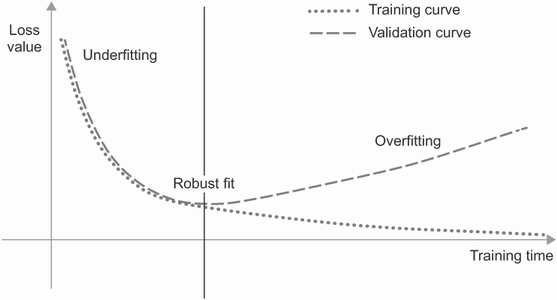

At the beginning of training, optimization and generalization are correlated: the lower the loss on training data, the lower the loss on test data. While this is happening, your model is said to be underfit: there is still progress to be made; the network hasn’t yet modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops improving, validation metrics stall and then begin to degrade: the model is starting to overfit. That is, it’s beginning to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data.

Overfitting is particularly likely to occur when your data is noisy, if it involves uncertainty, or if it includes rare features. Let’s look at concrete examples.

NOISY TRAINING DATA

In real-world datasets, it’s fairly common for some inputs to be invalid. Perhaps a MNIST digit could be an all-black image, for instance, or something like figur

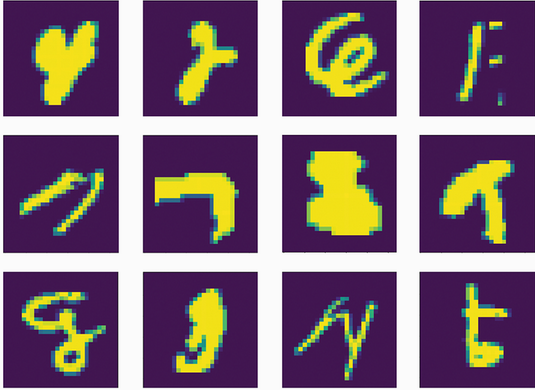

What are these? I don’t know either. But they’re all part of the MNIST training set. What’s even worse, however, is having perfectly valid inputs that end up mislabeled, like those in figure 5.3.

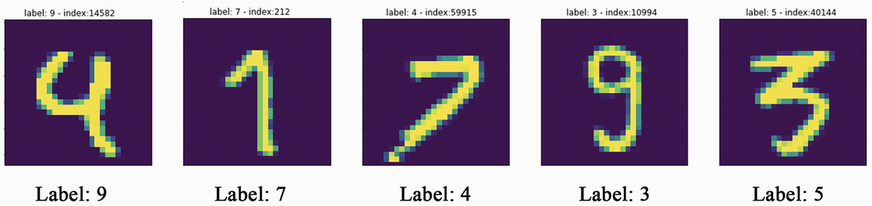

If a model goes out of its way to incorporate such outliers, its generalization performance will degrade, as shown in figure 5.4. For instance, a 4 that looks very close to the mislabeled 4 in figure 5.3 may end up getting classified as a 9.

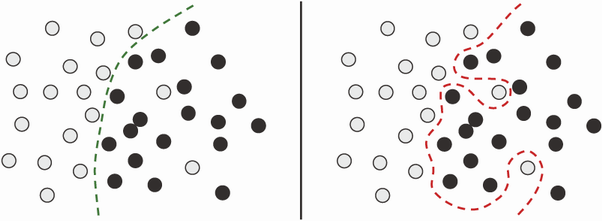e 5.2.

#### Noisy training data

#### Ambiguous features

Not all data noise comes from inaccuracies—even perfectly clean and neatly labeled data can be noisy when the problem involves uncertainty and ambiguity. In classification tasks, it is often the case that some regions of the input feature space are associated with multiple classes at the same time. Let’s say you’re developing a model that takes an image of a banana and predicts whether the banana is unripe, ripe, or rotten. These categories have no objective boundaries, so the same picture might be classified as either unripe or ripe by different human labelers. Similarly, many problems involve randomness. You could use atmospheric pressure data to predict whether it will rain tomorrow, but the exact same measurements may be followed sometimes by rain and sometimes by a clear sky, with some probability.

A model could overfit to such probabilistic data by being too confident about ambiguous regions of the feature space, like in figure 5.5. A more robust fit would ignore individual data points and look at the bigger pictur

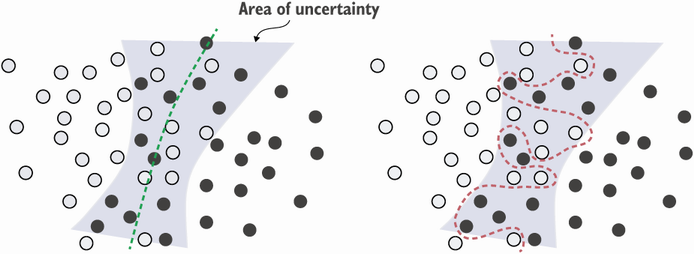e.

#### Rare features and spurious correlations

If you’ve only ever seen two orange tabby cats in your life, and they both happened to be terribly antisocial, you might infer that orange tabby cats are generally likely to be antisocial. That’s overfitting: if you had been exposed to a wider variety of cats, including more orange ones, you’d have learned that cat color is not well correlated with character.

Likewise, machine learning models trained on datasets that include rare feature values are highly susceptible to overfitting. In a sentiment classification task, if the word “cherimoya” (a fruit native to the Andes) only appears in one text in the training data, and this text happens to be negative in sentiment, a poorly regularized model might put a very high weight on this word and always classify new texts that mention cherimoyas as negative, whereas, objectively, there’s nothing negative about the cherimoya.1

1 Mark Twain even called it “the most delicious fruit known to men.”

Importantly, a feature value doesn’t need to occur only a couple of times to lead to spurious correlations. Consider a word that occurs in 100 samples in your training data and that’s associated with a positive sentiment 54% of the time and with a negative sentiment 46% of the time. That difference may well be a complete statistical fluke, yet your model is likely to learn to leverage that feature for its classification task. This is one of the most common sources of overfitting.

Here’s a striking example. Take MNIST. Create a new training set by concatenating 784 white noise dimensions to the existing 784 dimensions of the data, so half of the data is now noise. For comparison, also create an equivalent dataset by concatenating 784 all-zeros dimensions. Our concatenation of meaningless features does not at all affect the information content of the data: we’re only adding something. Human classification accuracy wouldn’t be affected by these transformations
 at all.

**Adding white-noise channels or all-zeros channels to MNIST**

In [2]:
from tensorflow.keras.datasets import mnist
import numpy as np

#####################################################
# improves how tensorflow allocates memory.  Goes as needed instead of all at once
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
       tf.config.experimental.set_memory_growth(gpu,True)
###############################################################
# If you are creating many models in a loop, this global state will consume an increasing amount of memory over time, and you may want to clear it. Calling clear_session() releases the global state: this helps avoid clutter from old models and layers, especially when memory is limited.
# tf.keras.backend.clear_session()
#############################################################
# set environmental variable
# %env TF_ENABLE_GPU_GARBAGE_COLLECTION=True

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
######################################################################
# added this line to speed training (but reduces accuracy due to fewer images)
train_images = train_images[:5000]
train_labels = train_labels[:5000]
##############################################################################

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1)

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)

**Training the same model on MNIST data with noise channels or all-zero channels**

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")  # softmax and 10 output neurons means it can classify ten different categories
    ])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])  # sparse categorical crossentropy for more than two categories of data
    return model

model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
32/32 [==============================] - 1s 15ms/step - loss: 1.9526 - accuracy: 0.5115 - val_loss: 1.3603 - val_accuracy: 0.6000
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 0.8113 - accuracy: 0.7642 - val_loss: 0.8867 - val_accuracy: 0.6920
Epoch 3/10
32/32 [==============================] - 0s 6ms/step - loss: 0.6006 - accuracy: 0.8108 - val_loss: 0.5141 - val_accuracy: 0.8250
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.4783 - accuracy: 0.8495 - val_loss: 0.7923 - val_accuracy: 0.7330
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.3977 - accuracy: 0.8710 - val_loss: 1.2870 - val_accuracy: 0.6030
Epoch 6/10
32/32 [==============================] - 0s 6ms/step - loss: 0.3565 - accuracy: 0.8923 - val_loss: 0.5463 - val_accuracy: 0.8370
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.2896 - accuracy: 0.9103 - val_loss: 0.3903 - val_accuracy: 0.8830
Epoch 8/10
32/32 [=

**Plotting a validation accuracy comparison**

Despite the data holding the same information in both cases, the validation accuracy of the model trained with noise channels ends up about one percentage point lower (see figure 5.6)—purely through the influence of spurious correlations. The more noise channels you add, the further accuracy will degrade.

Noisy features inevitably lead to overfitting. As such, in cases where you aren’t sure whether the features you have are informative or distracting, it’s common to do feature selection before training. Restricting the IMDB data to the top 10,000 most common words was a crude form of feature selection, for instance. The typical way to do feature selection is to compute some usefulness score for each feature available—a measure of how informative the feature is with respect to the task, such as the mutual information between the feature and the labels—and only keep features that are above some threshold. Doing this would filter out the white noise channels in the preceding example.

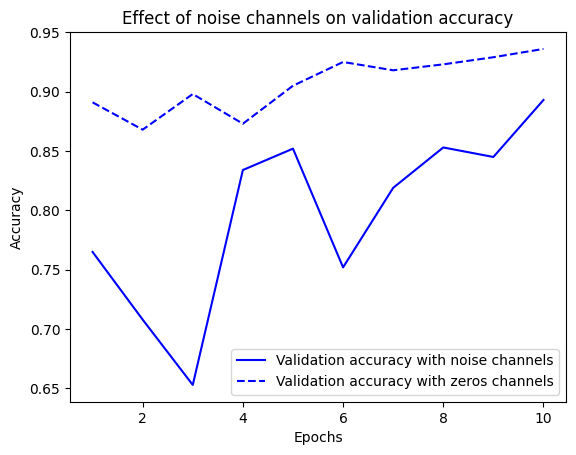

In [3]:
import matplotlib.pyplot as plt
val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

### The nature of generalization in deep learning

A remarkable fact about deep learning models is that they can be trained to fit anything, as long as they have enough representational power.

Don’t believe me? Try shuffling the MNIST labels and train a model on that. Even though there is no relationship whatsoever between the inputs and the shuffled labels, the training loss goes down just fine, even with a relatively small model. Naturally, the validation loss does not improve at all over time, since there is no possibility of generalization in this setting.

**Fitting a MNIST model with randomly shuffled labels**

Training accuracy ends up at 99.8% and validation accuracy is 9.9%.  The model fit the data, but the validation accuracy is just a random guess.

In [4]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
######################################################################
# added this line to speed training (but reduces accuracy due to fewer images)
train_images = train_images[:5000]
train_labels = train_labels[:5000]
##############################################################################

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, random_train_labels,
          epochs=100,
          batch_size=128,
          validation_split=0.2)

Epoch 1/100
32/32 [==============================] - 1s 9ms/step - loss: 2.3608 - accuracy: 0.1095 - val_loss: 2.3447 - val_accuracy: 0.0990
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 2.2585 - accuracy: 0.1552 - val_loss: 2.3688 - val_accuracy: 0.0990
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 2.2040 - accuracy: 0.1928 - val_loss: 2.3991 - val_accuracy: 0.1150
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 2.1499 - accuracy: 0.2292 - val_loss: 2.4064 - val_accuracy: 0.0910
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 2.0991 - accuracy: 0.2508 - val_loss: 2.4809 - val_accuracy: 0.0930
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 2.0430 - accuracy: 0.2905 - val_loss: 2.4587 - val_accuracy: 0.1070
Epoch 7/100
32/32 [==============================] - 0s 7ms/step - loss: 1.9930 - accuracy: 0.3158 - val_loss: 2.4597 - val_accuracy: 0.0990
Epoch 8/100
3

#### The manifold hypothesis

In fact, you don’t even need to do this with MNIST data—you could just generate white noise inputs and random labels. You could fit a model on that, too, as long as it has enough parameters. It would just end up memorizing specific inputs, much like a Python dictionary.

If this is the case, then how come deep learning models generalize at all? Shouldn’t they just learn an ad hoc mapping between training inputs and targets, like a fancy dict? What expectation can we have that this mapping will work for new inputs?

As it turns out, the nature of generalization in deep learning has rather little to do with deep learning models themselves, and much to do with the structure of information in the real world. Let’s take a look at what’s really going on h

The input to an MNIST classifier (before preprocessing) is a 28 × 28 array of integers between 0 and 255. The total number of possible input values is thus 256 to the power of 784—much greater than the number of atoms in the universe. However, very few of these inputs would look like valid MNIST samples: actual handwritten digits only occupy a tiny subspace of the parent space of all possible 28 × 28 uint8 arrays. What’s more, this subspace isn’t just a set of points sprinkled at random in the parent space: it is highly structured.

First, the subspace of valid handwritten digits is continuous: if you take a sample and modify it a little, it will still be recognizable as the same handwritten digit. Further, all samples in the valid subspace are connected by smooth paths that run through the subspace. This means that if you take two random MNIST digits A and B, there exists a sequence of “intermediate” images that morph A into B, such that two consecutive digits are very close to each other (see figure 5.7). Perhaps there will be a few ambiguous shapes close to the boundary between two classes, but even these shapes would still look very digit-lik
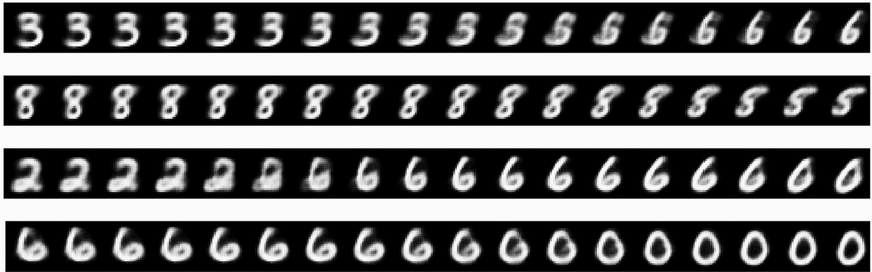

Figure 5.7 Different MNIST digits gradually morphing into one another, showing that the space of handwritten digits forms a “manifold.” This image was generated using code from chapter 12.

In technical terms, you would say that handwritten digits form a manifold within the space of possible 28 × 28 uint8 arrays. That’s a big word, but the concept is pretty intuitive. A “manifold” is a lower-dimensional subspace of some parent space that is locally similar to a linear (Euclidian) space. For instance, a smooth curve in the plane is a 1D manifold within a 2D space, because for every point of the curve, you can draw a tangent (the curve can be approximated by a line at every point). A smooth surface within a 3D space is a 2D manifold. And so on.

More generally, the manifold hypothesis posits that all natural data lies on a low-dimensional manifold within the high-dimensional space where it is encoded. That’s a pretty strong statement about the structure of information in the universe. As far as we know, it’s accurate, and it’s the reason why deep learning works. It’s true for MNIST digits, but also for human faces, tree morphology, the sounds of the human voice, and even natural language.

The manifold hypothesis implies that

Machine learning models only have to fit relatively simple, low-dimensional, highly structured subspaces within their potential input space (latent manifolds).

Within one of these manifolds, it’s always possible to interpolate between two inputs, that is to say, morph one into another via a continuous path along which all points fall on the manifold.

The ability to interpolate between samples is the key to understanding generalization in deep learning.e.ere.

#### Interpolation as a source of generalization

If you work with data points that can be interpolated, you can start making sense of points you’ve never seen before by relating them to other points that lie close on the manifold. In other words, you can make sense of the totality of the space using only a sample of the space. You can use interpolation to fill in the blanks.

Note that interpolation on the latent manifold is different from linear interpolation in the parent space, as illustrated in figure 5.8. For instance, the average of pixels between two MNIST digits is usually not a valid digi


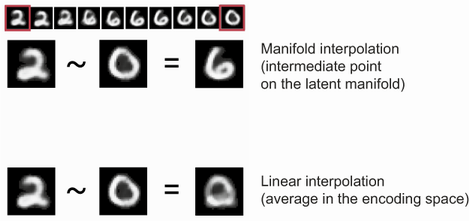

Figure 5.8 Difference between linear interpolation and interpolation on the latent manifold. Every point on the latent manifold of digits is a valid digit, but the average of two digits usually isn’t.

Crucially, while deep learning achieves generalization via interpolation on a learned approximation of the data manifold, it would be a mistake to assume that interpolation is all there is to generalization. It’s the tip of the iceberg. Interpolation can only help you make sense of things that are very close to what you’ve seen before: it enables local generalization. But remarkably, humans deal with extreme novelty all the time, and they do just fine. You don’t need to be trained in advance on countless examples of every situation you’ll ever have to encounter. Every single one of your days is different from any day you’ve experienced before, and different from any day experienced by anyone since the dawn of humanity. You can switch between spending a week in NYC, a week in Shanghai, and a week in Bangalore without requiring thousands of lifetimes of learning and rehearsal for each city.

Humans are capable of extreme generalization, which is enabled by cognitive mechanisms other than interpolation: abstraction, symbolic models of the world, reasoning, logic, common sense, innate priors about the world—what we generally call reason, as opposed to intuition and pattern recognition. The latter are largely interpolative in nature, but the former isn’t. Both are essential to intelligence. We’ll talk more about this in chapter 14.t.

#### Why deep learning works

Remember the crumpled paper ball metaphor from chapter 2? A sheet of paper represents a 2D manifold within 3D space (see figure 5.9). A deep learning model is a tool for uncrumpling paper balls, that is, for disentangling latent manifolds.
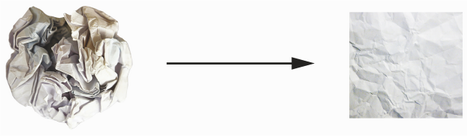


Figure 5.9 Uncrumpling a complicated manifold of data

A deep learning model is basically a very high-dimensional curve—a curve that is smooth and continuous (with additional constraints on its structure, originating from model architecture priors), since it needs to be differentiable. And that curve is fitted to data points via gradient descent, smoothly and incrementally. By its very nature, deep learning is about taking a big, complex curve—a manifold—and incrementally adjusting its parameters until it fits some training data points.

The curve involves enough parameters that it could fit anything—indeed, if you let your model train for long enough, it will effectively end up purely memorizing its training data and won’t generalize at all. However, the data you’re fitting to isn’t made of isolated points sparsely distributed across the underlying space. Your data forms a highly structured, low-dimensional manifold within the input space—that’s the manifold hypothesis. And because fitting your model curve to this data happens gradually and smoothly over time as gradient descent progresses, there will be an intermediate point during training at which the model roughly approximates the natural manifold of the data, as you can see in figu

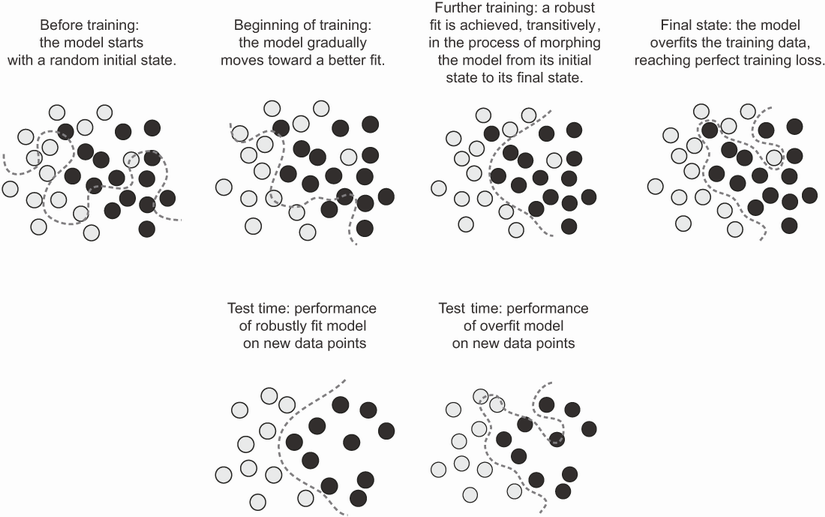

Moving along the curve learned by the model at that point will come close to moving along the actual latent manifold of the data—as such, the model will be capable of making sense of never-before-seen inputs via interpolation between training inputs.

Besides the trivial fact that they have sufficient representational power, there are a few properties of deep learning models that make them particularly well-suited to learning latent manifolds:

Deep learning models implement a smooth, continuous mapping from their inputs to their outputs. It has to be smooth and continuous because it must be differentiable, by necessity (you couldn’t do gradient descent otherwise). This smoothness helps approximate latent manifolds, which follow the same properties.

Deep learning models tend to be structured in a way that mirrors the “shape” of the information in their training data (via architecture priors). This is particularly the case for image-processing models (discussed in chapters 8 and 9) and sequence-processing models (chapter 10). More generally, deep neural networks structure their learned representations in a hierarchical and modular way, which echoes the way natural data is organized.re 5.10.

#### Training data is paramount

While deep learning is indeed well suited to manifold learning, the power to generalize is more a consequence of the natural structure of your data than a consequence of any property of your model. You’ll only be able to generalize if your data forms a manifold where points can be interpolated. The more informative and the less noisy your features are, the better you will be able to generalize, since your input space will be simpler and better structured. Data curation and feature engineering are essential to generalization.

Further, because deep learning is curve fitting, for a model to perform well it needs to be trained on a dense sampling of its input space. A “dense sampling” in this context means that the training data should densely cover the entirety of the input data manifold (see figure 5.11). This is especially true near decision boundaries. With a sufficiently dense sampling, it becomes possible to make sense of new inputs by interpolating between past training inputs without having to use common sense, abstract reasoning, or external knowledge about the world—all things that machine learning models have no access t

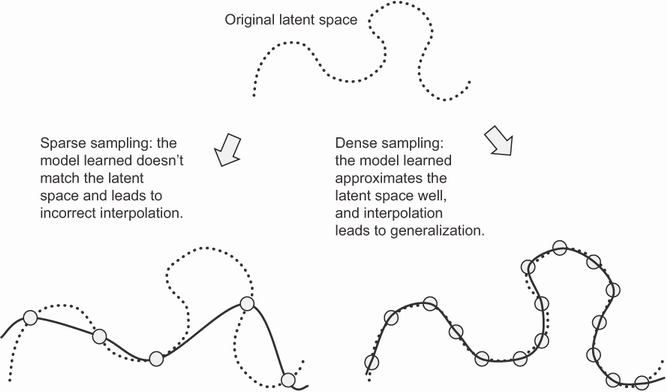

Figure 5.11 A dense sampling of the input space is necessary in order to learn a model capable of accurate generalization.

As such, you should always keep in mind that the best way to improve a deep learning model is to train it on more data or better data (of course, adding overly noisy or inaccurate data will harm generalization). A denser coverage of the input data manifold will yield a model that generalizes better. You should never expect a deep learning model to perform anything more than crude interpolation between its training samples, and thus you should do everything you can to make interpolation as easy as possible. The only thing you will find in a deep learning model is what you put into it: the priors encoded in its architecture and the data it was trained on.

When getting more data isn’t possible, the next best solution is to modulate the quantity of information that your model is allowed to store, or to add constraints on the smoothness of the model curve. If a network can only afford to memorize a small number of patterns, or very regular patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well. The process of fighting overfitting this way is called regularization. We’ll review regularization techniques in depth in section 5.4.4.

Before you can start tweaking your model to help it generalize better, you’ll need a way to assess how your model is currently doing. In the following section, you’ll learn how you can monitor generalization during model development: model evaluation.o.

## Evaluating machine-learning models

### Training, validation, and test sets

Evaluating a model always boils down to splitting the available data into three sets: training, validation, and test. You train on the training data and evaluate your model on the validation data. Once your model is ready for prime time, you test it one final time on the test data, which is meant to be as similar as possible to production data. Then you can deploy the model in production.

You may ask, why not have two sets: a training set and a test set? You’d train on the training data and evaluate on the test data. Much simpler!

The reason is that developing a model always involves tuning its configuration: for example, choosing the number of layers or the size of the layers (called the hyperparameters of the model, to distinguish them from the parameters, which are the network’s weights). You do this tuning by using as a feedback signal the performance of the model on the validation data. In essence, this tuning is a form of learning: a search for a good configuration in some parameter space. As a result, tuning the configuration of the model based on its performance on the validation set can quickly result in overfitting to the validation set, even though your model is never directly trained on it.

Central to this phenomenon is the notion of information leaks. Every time you tune a hyperparameter of your model based on the model’s performance on the validation set, some information about the validation data leaks into the model. If you do this only once, for one parameter, then very few bits of information will leak, and your validation set will remain reliable for evaluating the model. But if you repeat this many times—running one experiment, evaluating on the validation set, and modifying your model as a result—then you’ll leak an increasingly significant amount of information about the validation set into the model.

At the end of the day, you’ll end up with a model that performs artificially well on the validation data, because that’s what you optimized it for. You care about performance on completely new data, not on the validation data, so you need to use a completely different, never-before-seen dataset to evaluate the model: the test dataset. Your model shouldn’t have had access to any information about the test set, even indirectly. If anything about the model has been tuned based on test set performance, then your measure of generalization will be flawed.

Splitting your data into training, validation, and test sets may seem straightforward, but there are a few advanced ways to do it that can come in handy when little data is available. Let’s review three classic evaluation recipes: simple holdout validation, K-fold validation, and iterated K-fold validation with shuffling. We’ll also talk about the use of common-sense baselines to check that your training is going somewhere.

#### Simple hold-out validation

Set apart some fraction of your data as your test set. Train on the remaining data, and evaluate on the test set. As you saw in the previous sections, in order to prevent information leaks, you shouldn’t tune your model based on the test set, and therefore you should also reserve a validation set.

#### K-fold validation

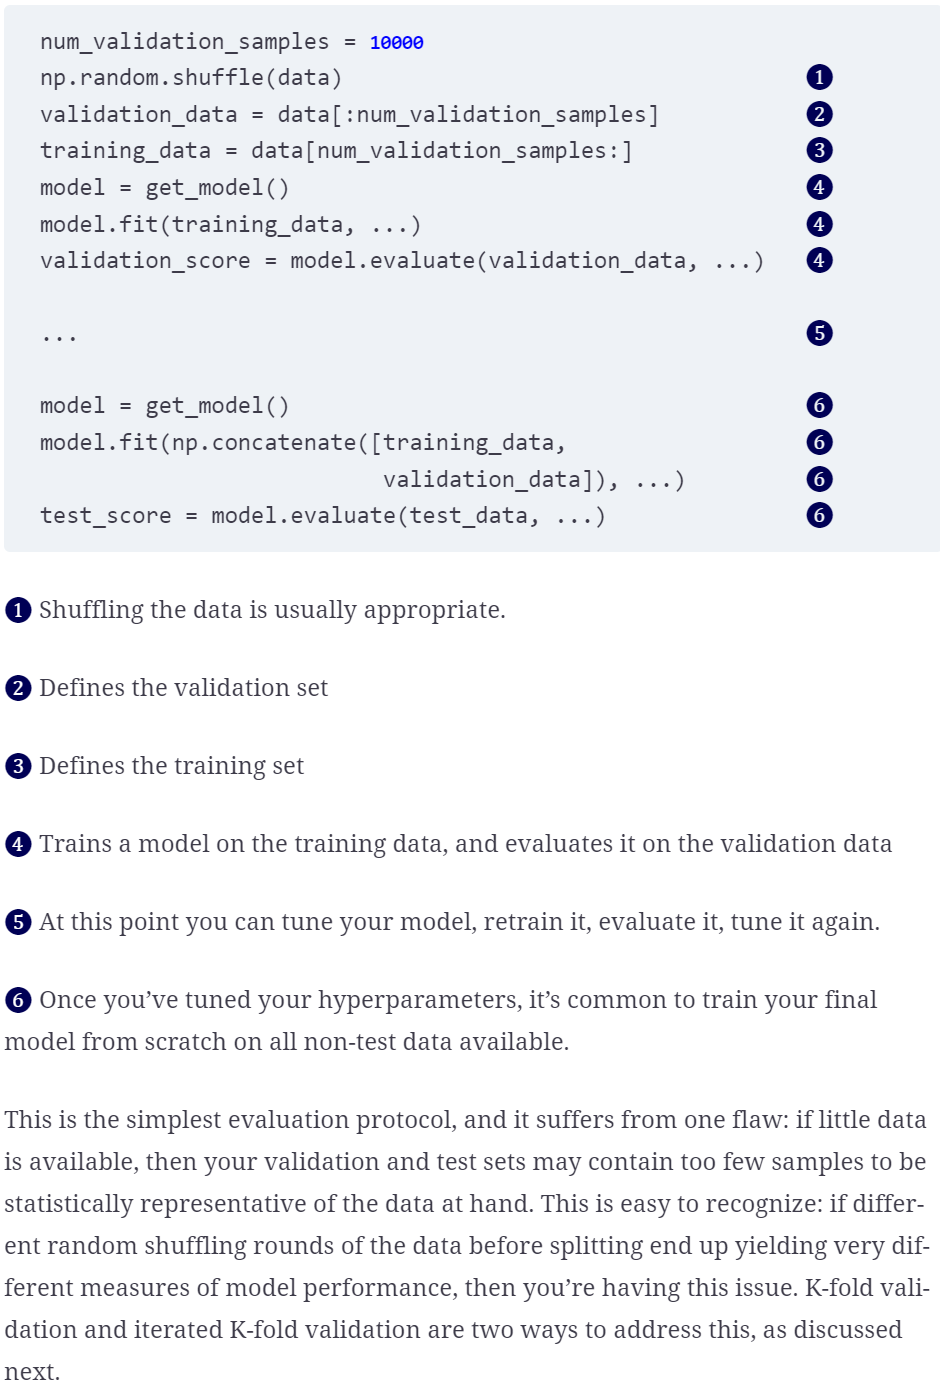 this, as discussed next.

#### Iterated K-fold validation with shuffling

Use scikitlearn test_train_split() when possible

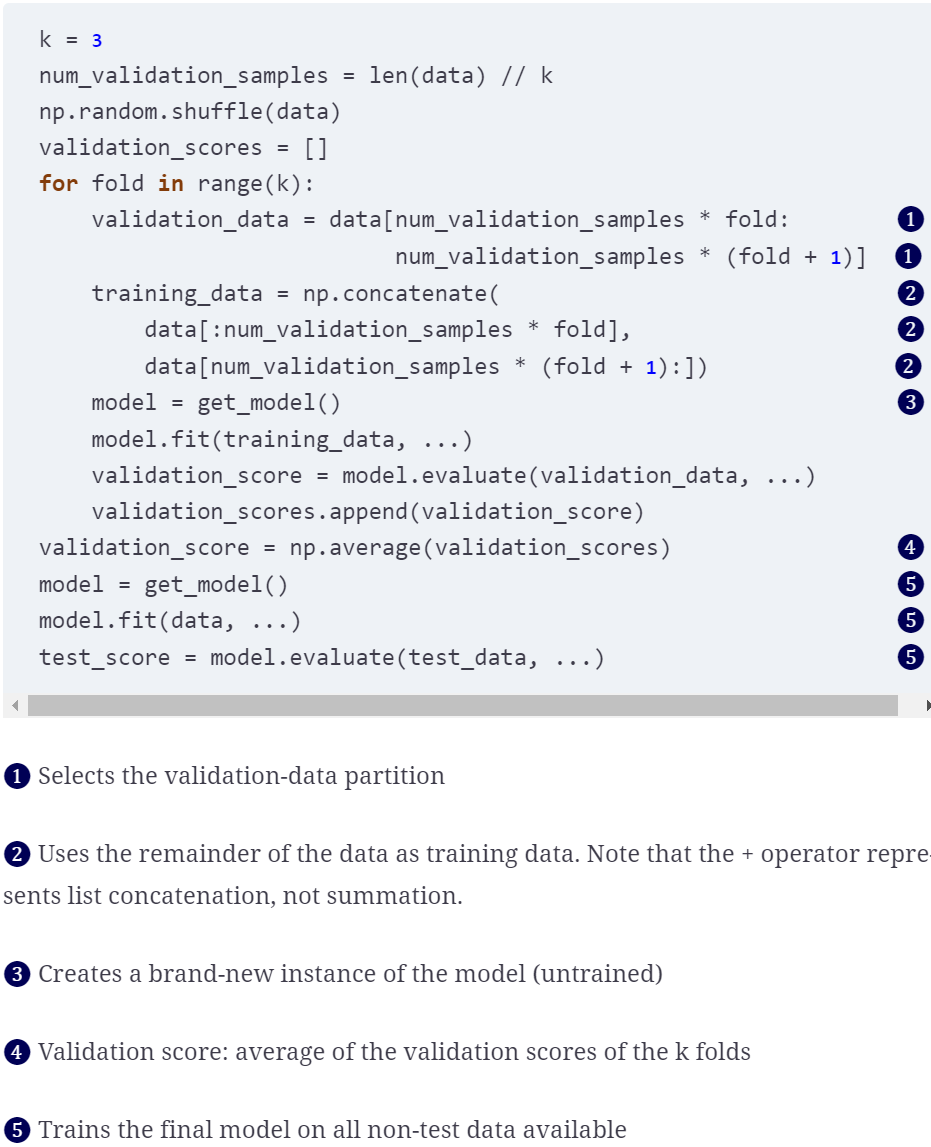

### Beating a common-sense baseline

Besides the different evaluation protocols you have available, one last thing you should know about is the use of common-sense baselines.

Training a deep learning model is a bit like pressing a button that launches a rocket in a parallel world. You can’t hear it or see it. You can’t observe the manifold learning process—it’s happening in a space with thousands of dimensions, and even if you projected it to 3D, you couldn’t interpret it. The only feedback you have is your validation metrics—like an altitude meter on your invisible rocket.

It’s particularly important to be able to tell whether you’re getting off the ground at all. What was the altitude you started at? Your model seems to have an accuracy of 15%—is that any good? Before you start working with a dataset, you should always pick a trivial baseline that you’ll try to beat. If you cross that threshold, you’ll know you’re doing something right: your model is actually using the information in the input data to make predictions that generalize, and you can keep going. This baseline could be the performance of a random classifier, or the performance of the simplest non-machine learning technique you can imagine.

For instance, in the MNIST digit-classification example, a simple baseline would be a validation accuracy greater than 0.1 (random classifier); in the IMDB example, it would be a validation accuracy greater than 0.5. In the Reuters example, it would be around 0.18-0.19, due to class imbalance. If you have a binary classification problem where 90% of samples belong to class A and 10% belong to class B, then a classifier that always predicts A already achieves 0.9 in validation accuracy, and you’ll need to do better than that.

Having a common-sense baseline you can refer to is essential when you’re getting started on a problem no one has solved before. If you can’t beat a trivial solution, your model is worthless—perhaps you’re using the wrong model, or perhaps the problem you’re tackling can’t even be approached with machine learning in the first place. Time to go back to the drawing board.

### Things to keep in mind about model evaluation

Keep an eye out for the following when you’re choosing an evaluation protocol:

Data representativeness—You want both your training set and test set to be representative of the data at hand. For instance, if you’re trying to classify images of digits, and you’re starting from an array of samples where the samples are ordered by their class, taking the first 80% of the array as your training set and the remaining 20% as your test set will result in your training set containing only classes 0–7, whereas your test set will contain only classes 8–9. This seems like a ridiculous mistake, but it’s surprisingly common. For this reason, you usually should randomly shuffle your data before splitting it into training and test sets.

The arrow of time—If you’re trying to predict the future given the past (for example, tomorrow’s weather, stock movements, and so on), you should not randomly shuffle your data before splitting it, because doing so will create a temporal leak: your model will effectively be trained on data from the future. In such situations, you should always make sure all data in your test set is posterior to the data in the training set.

Redundancy in your data—If some data points in your data appear twice (fairly common with real-world data), then shuffling the data and splitting it into a training set and a validation set will result in redundancy between the training and validation sets. In effect, you’ll be testing on part of your training data, which is the worst thing you can do! Make sure your training set and validation set are disjoint.

Having a reliable way to evaluate the performance of your model is how you’ll be able to monitor the tension at the heart of machine learning—between optimization and generalization, underfitting and overfitting.

## Improving model fit

To achieve the perfect fit, you must first overfit. Since you don’t know in advance where the boundary lies, you must cross it to find it. Thus, your initial goal as you start working on a problem is to achieve a model that shows some generalization power and that is able to overfit. Once you have such a model, you’ll focus on refining generalization by fighting overfitting.

There are three common problems you’ll encounter at this stage:

Training doesn’t get started: your training loss doesn’t go down over time.

Training gets started just fine, but your model doesn’t meaningfully generalize: you can’t beat the common-sense baseline you set.

Training and validation loss both go down over time, and you can beat your baseline, but you don’t seem to be able to overfit, which indicates you’re still underfitting.

Let’s see how you can address these issues to achieve the first big milestone of a machine learning project: getting a model that has some generalization power (it can beat a trivial baseline) and that is able to overfit.

### Tuning key gradient descent parameters

**Training a MNIST model with an incorrectly high learning rate**

optimizer=keras.optimizers.RMSprop(1.)

In [5]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

######################################################################
# added this line to speed training (but reduces accuracy due to fewer images)
train_images = train_images[:5000]
train_labels = train_labels[:5000]
##############################################################################

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1.),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
32/32 [==============================] - 1s 9ms/step - loss: 8077.7847 - accuracy: 0.6313 - val_loss: 42.8274 - val_accuracy: 0.7320
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 17.2659 - accuracy: 0.6693 - val_loss: 60.9315 - val_accuracy: 0.6040
Epoch 3/10
32/32 [==============================] - 0s 6ms/step - loss: 103.0781 - accuracy: 0.5328 - val_loss: 5.2110 - val_accuracy: 0.5110
Epoch 4/10
32/32 [==============================] - 0s 7ms/step - loss: 24.2583 - accuracy: 0.5048 - val_loss: 5.6379 - val_accuracy: 0.4650
Epoch 5/10
32/32 [==============================] - 0s 6ms/step - loss: 2.7639 - accuracy: 0.4360 - val_loss: 3.2199 - val_accuracy: 0.4110
Epoch 6/10
32/32 [==============================] - 0s 7ms/step - loss: 22.1524 - accuracy: 0.4255 - val_loss: 2.0391 - val_accuracy: 0.3230
Epoch 7/10
32/32 [==============================] - 0s 6ms/step - loss: 4.8874 - accuracy: 0.3618 - val_loss: 2.7644 - val_accuracy: 0.3530
Epoch 8/10

The model quickly reaches a training and validation accuracy in the 30%–40% range, but cannot get past that. Let’s try to lower the learning rate to a more reasonable value of 1e-2.

**The same model with a more appropriate learning rate**

optimizer=keras.optimizers.RMSprop(1e-2)

If you find yourself where the training accuracy is not improving, try

Lowering or increasing the learning rate. A learning rate that is too high may lead to updates that vastly overshoot a proper fit, like in the preceding example, and a learning rate that is too low may make training so slow that it appears to stall.

Increasing the batch size. A batch with more samples will lead to gradients that are more informative and less noisy (lower variance).

In [6]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
32/32 [==============================] - 1s 11ms/step - loss: 1.9270 - accuracy: 0.7080 - val_loss: 1.0379 - val_accuracy: 0.6850
Epoch 2/10
32/32 [==============================] - 0s 8ms/step - loss: 0.4061 - accuracy: 0.8733 - val_loss: 0.4027 - val_accuracy: 0.8750
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2161 - accuracy: 0.9348 - val_loss: 0.2701 - val_accuracy: 0.9270
Epoch 4/10
32/32 [==============================] - 0s 6ms/step - loss: 0.1686 - accuracy: 0.9465 - val_loss: 0.7085 - val_accuracy: 0.8440
Epoch 5/10
32/32 [==============================] - 0s 7ms/step - loss: 0.1255 - accuracy: 0.9622 - val_loss: 0.2492 - val_accuracy: 0.9320
Epoch 6/10
32/32 [==============================] - 0s 7ms/step - loss: 0.0807 - accuracy: 0.9750 - val_loss: 0.2518 - val_accuracy: 0.9400
Epoch 7/10
32/32 [==============================] - 0s 7ms/step - loss: 0.0641 - accuracy: 0.9795 - val_loss: 0.3006 - val_accuracy: 0.9420
Epoch 8/10
32/32 [=

### Leveraging better architecture priors

You have a model that fits, but for some reason your validation metrics aren’t improving at all. They remain no better than what a random classifier would achieve: your model trains but doesn’t generalize. What’s going on?

This is perhaps the worst machine learning situation you can find yourself in. It indicates that something is fundamentally wrong with your approach, and it may not be easy to tell what. Here are some tips.

First, it may be that the input data you’re using simply doesn’t contain sufficient information to predict your targets: the problem as formulated is not solvable. This is what happened earlier when we tried to fit an MNIST model where the labels were shuffled: the model would train just fine, but validation accuracy would stay stuck at 10%, because it was plainly impossible to generalize with such a dataset.

It may also be that the kind of model you’re using is not suited for the problem at hand. For instance, in chapter 10, you’ll see an example of a timeseries prediction problem where a densely connected architecture isn’t able to beat a trivial baseline, whereas a more appropriate recurrent architecture does manage to generalize well. Using a model that makes the right assumptions about the problem is essential to achieve generalization: you should leverage the right architecture priors.

In the following chapters, you’ll learn about the best architectures to use for a variety of data modalities—images, text, timeseries, and so on. In general, you should always make sure to read up on architecture best practices for the kind of task you’re attacking—chances are you’re not the first person to attempt it.

### Increasing model capacity

If you manage to get to a model that fits, where validation metrics are going down, and that seems to achieve at least some level of generalization power, congratulations: you’re almost there. Next, you need to get your model to start overfitting.

Consider the following small model—a simple logistic regression—trained on MNIST pixels.

**A simple logistic regression on MNIST**

In [14]:
model = keras.Sequential([layers.Dense(10, activation="softmax")])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_small_model = model.fit(
    train_images, train_labels,
    epochs=40,
    batch_size=128,
    validation_split=0.2)

Epoch 1/40
32/32 [==============================] - 1s 10ms/step - loss: 1.6862 - accuracy: 0.5587 - val_loss: 1.2657 - val_accuracy: 0.7430
Epoch 2/40
32/32 [==============================] - 0s 7ms/step - loss: 1.0613 - accuracy: 0.8030 - val_loss: 0.8929 - val_accuracy: 0.8160
Epoch 3/40
32/32 [==============================] - 0s 6ms/step - loss: 0.7779 - accuracy: 0.8422 - val_loss: 0.7003 - val_accuracy: 0.8550
Epoch 4/40
32/32 [==============================] - 0s 5ms/step - loss: 0.6239 - accuracy: 0.8605 - val_loss: 0.5897 - val_accuracy: 0.8690
Epoch 5/40
32/32 [==============================] - 0s 5ms/step - loss: 0.5309 - accuracy: 0.8752 - val_loss: 0.5265 - val_accuracy: 0.8750
Epoch 6/40
32/32 [==============================] - 0s 5ms/step - loss: 0.4709 - accuracy: 0.8870 - val_loss: 0.4777 - val_accuracy: 0.8880
Epoch 7/40
32/32 [==============================] - 0s 5ms/step - loss: 0.4274 - accuracy: 0.8930 - val_loss: 0.4490 - val_accuracy: 0.8940
Epoch 8/40
32/32 [=

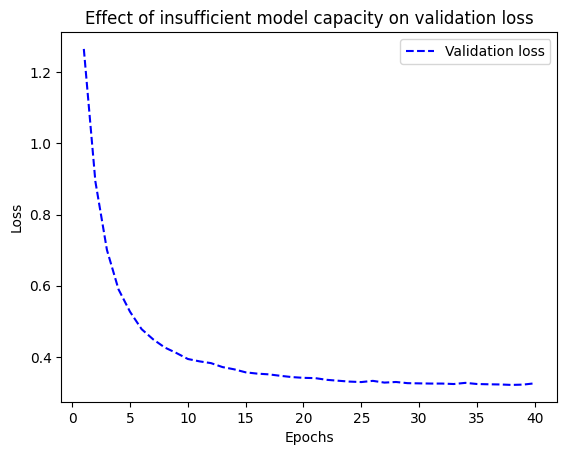

In [16]:
import matplotlib.pyplot as plt
val_loss = history_small_model.history["val_loss"]
epochs = range(1, 41)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Validation metrics seem to stall, or to improve very slowly, instead of peaking and reversing course. The validation loss goes to 0.26 and just stays there. You can fit, but you can’t clearly overfit, even after many iterations over the training data. You’re likely to encounter similar curves often in your career.

Remember that it should always be possible to overfit. Much like the problem where the training loss doesn’t go down, this is an issue that can always be solved. If you can’t seem to be able to overfit, it’s likely a problem with the representational power of your model: you’re going to need a bigger model, one with more capacity, that is to say, one able to store more information. You can increase representational power by adding more layers, using bigger layers (layers with more parameters), or using kinds of layers that are more appropriate for the problem at hand (better architecture priors).

Let’s try training a bigger model, one with two intermediate layers with 96 units each:

In [11]:
model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax"),
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_large_model = model.fit(
    train_images, train_labels,
    epochs=40,
    batch_size=128,
    validation_split=0.2)

Epoch 1/40
32/32 [==============================] - 1s 13ms/step - loss: 1.1242 - accuracy: 0.7003 - val_loss: 0.6079 - val_accuracy: 0.8180
Epoch 2/40
32/32 [==============================] - 0s 9ms/step - loss: 0.4400 - accuracy: 0.8817 - val_loss: 0.4248 - val_accuracy: 0.8720
Epoch 3/40
32/32 [==============================] - 0s 8ms/step - loss: 0.3177 - accuracy: 0.9150 - val_loss: 0.4436 - val_accuracy: 0.8810
Epoch 4/40
32/32 [==============================] - 0s 7ms/step - loss: 0.2609 - accuracy: 0.9265 - val_loss: 0.3417 - val_accuracy: 0.9030
Epoch 5/40
32/32 [==============================] - 0s 7ms/step - loss: 0.2234 - accuracy: 0.9367 - val_loss: 0.3106 - val_accuracy: 0.9150
Epoch 6/40
32/32 [==============================] - 0s 7ms/step - loss: 0.1882 - accuracy: 0.9482 - val_loss: 0.3623 - val_accuracy: 0.8970
Epoch 7/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1655 - accuracy: 0.9553 - val_loss: 0.2610 - val_accuracy: 0.9330
Epoch 8/40
32/32 [=

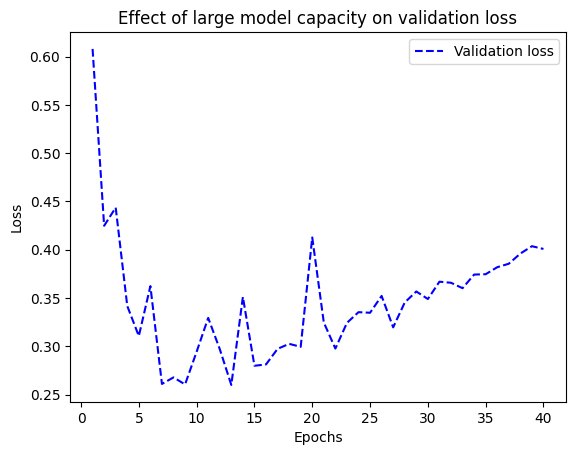

In [13]:
val_loss = history_large_model.history["val_loss"]
epochs = range(1, 41)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of large model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Improving generalization

### Dataset curation

You’ve already learned that generalization in deep learning originates from the latent structure of your data. If your data makes it possible to smoothly interpolate between samples, you will be able to train a deep learning model that generalizes. If your problem is overly noisy or fundamentally discrete, like, say, list sorting, deep learning will not help you. Deep learning is curve fitting, not magic.

As such, it is essential that you make sure that you’re working with an appropriate dataset. Spending more effort and money on data collection almost always yields a much greater return on investment than spending the same on developing a better model.

Make sure you have enough data. Remember that you need a dense sampling of the input-cross-output space. More data will yield a better model. Sometimes, problems that seem impossible at first become solvable with a larger dataset.

Minimize labeling errors—visualize your inputs to check for anomalies, and proofread your labels.

Clean your data and deal with missing values (we’ll cover this in the next chapter).

If you have many features and you aren’t sure which ones are actually useful, do feature selection.

A particularly important way to improve the generalization potential of your data is feature engineering. For most machine learning problems, feature engineering is a key ingredient for success. Let’s take a look.

### Feature engineering

Feature engineering is the process of using your own knowledge about the data and about the machine learning algorithm at hand (in this case, a neural network) to make the algorithm work better by applying hardcoded (non-learned) transformations to the data before it goes into the model. In many cases, it isn’t reasonable to expect a machine learning model to be able to learn from completely arbitrary data. The data needs to be presented to the model in a way that will make the model’s job easier.

Let’s look at an intuitive example. Suppose you’re trying to develop a model that can take as input an image of a clock and can output the time of d.

If you choose to use the raw pixels of the image as input data, you have a difficult machine learning problem on your hands. You’ll need a convolutional neural network to solve it, and you’ll have to expend quite a bit of computational resources to train the network.

But if you already understand the problem at a high level (you understand how humans read time on a clock face), you can come up with much better input features for a machine learning algorithm: for instance, it’s easy to write a five-line Python script to follow the black pixels of the clock hands and output the (x, y) coordinates of the tip of each hand. Then a simple machine learning algorithm can learn to associate these coordinates with the appropriate time of day.

You can go even further: do a coordinate change, and express the (x, y) coordinates as polar coordinates with regard to the center of the image. Your input will become the angle theta of each clock hand. At this point, your features are making the problem so easy that no machine learning is required; a simple rounding operation and dictionary lookup are enough to recover the approximate time of day.

That’s the essence of feature engineering: making a problem easier by expressing it in a simpler way. Make the latent manifold smoother, simpler, better organized. Doing so usually requires understanding the problem in depth.

Before deep learning, feature engineering used to be the most important part of the machine learning workflow, because classical shallow algorithms didn’t have hypothesis spaces rich enough to learn useful features by themselves. The way you presented the data to the algorithm was absolutely critical to its success. For instance, before convolutional neural networks became successful on the MNIST digit-classification problem, solutions were typically based on hardcoded features such as the number of loops in a digit image, the height of each digit in an image, a histogram of pixel values, and so on.

Fortunately, modern deep learning removes the need for most feature engineering, because neural networks are capable of automatically extracting useful features from raw data. Does this mean you don’t have to worry about feature engineering as long as you’re using deep neural networks? No, for t:

Good features still allow you to solve problems more elegantly while using fewer resources. For instance, it would be ridiculous to solve the problem of reading a clock face using a convolutional neural network.

Good features let you solve a problem with far less data. The ability of deep learning models to learn features on their own relies on having lots of training data available; if you have only a few samples, the information value in their features becomes critical.o reasons:ay

### Using early stopping

In deep learning, we always use models that are vastly overparameterized: they have way more degrees of freedom than the minimum necessary to fit to the latent manifold of the data. This overparameterization is not an issue, because you never fully fit a deep learning model. Such a fit wouldn’t generalize at all. You will always interrupt training long before you’ve reached the minimum possible training loss.

Finding the exact point during training where you’ve reached the most generalizable fit—the exact boundary between an underfit curve and an overfit curve—is one of the most effective things you can do to improve generalization.

In the examples in the previous chapter, we would start by training our models for longer than needed to figure out the number of epochs that yielded the best validation metrics, and then we would retrain a new model for exactly that number of epochs. This is pretty standard, but it requires you to do redundant work, which can sometimes be expensive. Naturally, you could just save your model at the end of each epoch, and once you’ve found the best epoch, reuse the closest saved model you have. In Keras, it’s typical to do this with an EarlyStopping callback, which will interrupt training as soon as validation metrics have stopped improving, while remembering the best known model state. You’ll learn to use callbacks in chapter 7.

### Regularizing your model

#### Reducing the network's size

You’ve already learned that a model that is too small will not overfit. The simplest way to mitigate overfitting is to reduce the size of the model (the number of learnable parameters in the model, determined by the number of layers and the number of units per layer). If the model has limited memorization resources, it won’t be able to simply memorize its training data; thus, in order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets—precisely the type of representations we’re interested in. At the same time, keep in mind that you should use models that have enough parameters that they don’t underfit: your model shouldn’t be starved for memorization resources. There is a compromise to be found between too much capacity and not enough capacity.

Unfortunately, there is no magical formula to determine the right number of layers or the right size for each layer. You must evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the correct model size for your data. The general workflow for finding an appropriate model size is to start with relatively few layers and parameters, and increase the size of the layers or add new layers until you see diminishing returns with regard to validation loss.

**Original model**

In [10]:
from tensorflow.keras.datasets import imdb
#######################################################
# reduced number of words to 5000, from 10000, to speed training
# (train_data, train_labels), _ = imdb.load_data(num_words=10000)
# changed vectorize_squences to 5000 as well
# def vectorize_sequences(sequences, dimension=10000):

(train_data, train_labels), _ = imdb.load_data(num_words=5000)

def vectorize_sequences(sequences, dimension=5000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 35ms/step - loss: 0.5928 - accuracy: 0.7545 - val_loss: 0.4824 - val_accuracy: 0.8383
Epoch 2/20
30/30 [==============================] - 1s 29ms/step - loss: 0.4076 - accuracy: 0.8665 - val_loss: 0.3607 - val_accuracy: 0.8704
Epoch 3/20
30/30 [==============================] - 1s 40ms/step - loss: 0.3027 - accuracy: 0.8969 - val_loss: 0.3325 - val_accuracy: 0.8645
Epoch 4/20
30/30 [==============================] - 1s 32ms/step - loss: 0.2493 - accuracy: 0.9103 - val_loss: 0.3009 - val_accuracy: 0.8792
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2165 - accuracy: 0.9201 - val_loss: 0.2847 - val_accuracy: 0.8876
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1958 - accuracy: 0.9283 - val_loss: 0.3088 - val_accuracy: 0.8749
Epoch 7/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1780 - accuracy: 0.9359 - val_loss: 0.2912 - val_accuracy: 0.8832
Epoch 8/20
30

**Version of the model with lower capacity**

Going from 16 - 16 - 1 to 4 - 4 - 1 layers

In [11]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_smaller_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 31ms/step - loss: 0.6208 - accuracy: 0.6948 - val_loss: 0.5505 - val_accuracy: 0.7492
Epoch 2/20
30/30 [==============================] - 0s 16ms/step - loss: 0.4880 - accuracy: 0.8453 - val_loss: 0.4562 - val_accuracy: 0.8427
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.3998 - accuracy: 0.8839 - val_loss: 0.3918 - val_accuracy: 0.8672
Epoch 4/20
30/30 [==============================] - 0s 16ms/step - loss: 0.3361 - accuracy: 0.9035 - val_loss: 0.3479 - val_accuracy: 0.8792
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2879 - accuracy: 0.9164 - val_loss: 0.3288 - val_accuracy: 0.8772
Epoch 6/20
30/30 [==============================] - 0s 17ms/step - loss: 0.2535 - accuracy: 0.9235 - val_loss: 0.3033 - val_accuracy: 0.8841
Epoch 7/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2274 - accuracy: 0.9306 - val_loss: 0.2939 - val_accuracy: 0.8843
Epoch 8/20
30

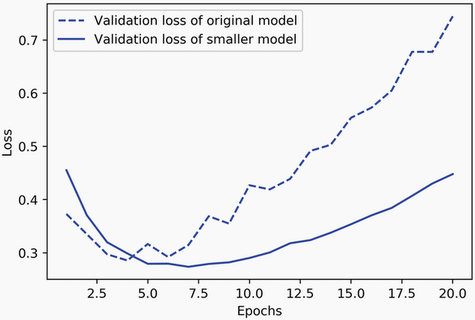

**Version of the model with higher capacity**

As you can see, the smaller model starts overfitting later than the reference model (after six epochs rather than four), and its performance degrades more slowly once it starts overfitting.

Now, let’s add to our benchmark a model that has much more capacity—far more than the problem warrants. While it is standard to work with models that are significantly overparameterized for what they’re trying to learn, there can definitely be such a thing as too much memorization capacity. You’ll know your model is too large if it starts overfitting right away and if its validation loss curve looks choppy with high-variance (although choppy validation metrics could also be a symptom of using an unreliable validation process, such as a validation split that’s too small).

This models has 512 - 512 - 1 layers

In [12]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_larger_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 32ms/step - loss: 0.5802 - accuracy: 0.7078 - val_loss: 0.3652 - val_accuracy: 0.8520
Epoch 2/20
30/30 [==============================] - 1s 17ms/step - loss: 0.3336 - accuracy: 0.8631 - val_loss: 0.3054 - val_accuracy: 0.8722
Epoch 3/20
30/30 [==============================] - 0s 17ms/step - loss: 0.2674 - accuracy: 0.8903 - val_loss: 0.3549 - val_accuracy: 0.8448
Epoch 4/20
30/30 [==============================] - 0s 17ms/step - loss: 0.2066 - accuracy: 0.9187 - val_loss: 0.2820 - val_accuracy: 0.8873
Epoch 5/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1786 - accuracy: 0.9311 - val_loss: 0.3052 - val_accuracy: 0.8767
Epoch 6/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1283 - accuracy: 0.9559 - val_loss: 0.3239 - val_accuracy: 0.8827
Epoch 7/20
30/30 [==============================] - 0s 17ms/step - loss: 0.0978 - accuracy: 0.9661 - val_loss: 0.5972 - val_accuracy: 0.8126
Epoch 8/20
30

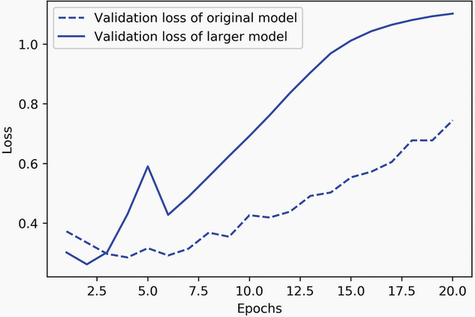

The bigger model starts overfitting almost immediately, after just one epoch, and it overfits much more severely. Its validation loss is also noisier. It gets training loss near zero very quickly. The more capacity the model has, the more quickly it can model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large difference between the training and validation loss).


#### Adding weight regularization

Simpler models are less likely to overfit than complex ones.

A simple model in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters, as you saw in the previous section). Thus, a common way to mitigate overfitting is to put constraints on the complexity of a model by forcing its weights to take only small values, which makes the distribution of weight values more regular. This is called weight regularization, and it’s done by adding to the loss function of the model a cost associated with having large weights. This cost comes in two flavors:

L1 regularization—The cost added is proportional to the absolute value of the weight coefficients (the L1 norm of the weights).

L2 regularization—The cost added is proportional to the square of the value of the weight coefficients (the L2 norm of the weights). L2 regularization is also called weight decay in the context of neural networks. Don’t let the different name confuse you: weight decay is mathematically the same as L2 regularization.

In Keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let’s add L2 weight regularization to our initial movie-review classification model.

**Adding L2 weight regularization to the model**

In [13]:
from tensorflow.keras import regularizers
model = keras.Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_l2_reg = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 30ms/step - loss: 0.6098 - accuracy: 0.7794 - val_loss: 0.4781 - val_accuracy: 0.8634
Epoch 2/20
30/30 [==============================] - 0s 16ms/step - loss: 0.4179 - accuracy: 0.8845 - val_loss: 0.4082 - val_accuracy: 0.8705
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3502 - accuracy: 0.9031 - val_loss: 0.3737 - val_accuracy: 0.8854
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3149 - accuracy: 0.9112 - val_loss: 0.3643 - val_accuracy: 0.8849
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2959 - accuracy: 0.9189 - val_loss: 0.3618 - val_accuracy: 0.8857
Epoch 6/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2815 - accuracy: 0.9250 - val_loss: 0.4189 - val_accuracy: 0.8611
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2690 - accuracy: 0.9302 - val_loss: 0.3723 - val_accuracy: 0.8790
Epoch 8/20
30

In the preceding listing, l2(0.002) means every coefficient in the weight matrix of the layer will add 0.002 * weight_coefficient_value ** 2 to the total loss of the model. Note that because this penalty is only added at training time, the loss for this model will be much higher at training than at test time.

Figure 5.19 shows the impact of the L2 regularization penalty. As you can see, the model with L2 regularization has become much more resistant to overfitting than the reference model, even though both models have the same number of parameters.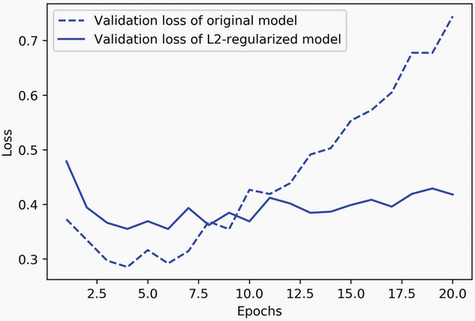



**Different weight regularizers available in Keras**

In [14]:
from tensorflow.keras import regularizers
regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)  # simulatneous L1 and L2 (ElasticNet model)

#### Adding dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks; it was developed by Geoff Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly dropping out (setting to zero) a number of output features of the layer during training. Let’s say a given layer would normally return a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training. After applying dropout, this vector will have a few zero entries distributed at random: for example, [0, 0.5, 1.3, 0, 1.1]. The dropout rate is the fraction of the features that are zeroed out; it’s usually set between 0.2 and 0.5. At test time, no units are dropped out; instead, the layer’s output values are scaled down by a factor equal to the dropout rate, to balance for the fact that more units are active than at training time.

Consider a NumPy matrix containing the output of a layer, layer_output, of shape (batch_size, features). At training time, we zero out at random a fraction of the values in the matrix:

**Adding dropout to the IMDB model**

The layers.Dropout(0.5), line drops 50% of the neurons output to zero

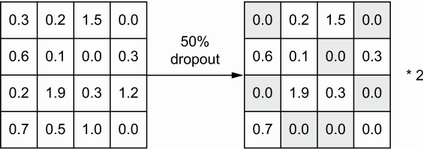

In [15]:
import gc  # python garbage collector
gc.collect() # frees up memory

3974

This technique may seem strange and arbitrary. Why would this help reduce overfitting? Hinton says he was inspired by, among other things, a fraud-prevention mechanism used by banks. In his own words, “I went to my bank. The tellers kept changing and I asked one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each example would prevent conspiracies and thus reduce overfitting.” The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that aren’t significant (what Hinton refers to as conspiracies), which the model will start memorizing if no noise is present.

In Keras, you can introduce dropout in a model via the Dropout layer, which is applied to the output of the layer right before it. Let’s add two Dropout layers in the IMDB model to see how well they do at reducing overfitting.

In [16]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 37ms/step - loss: 0.6598 - accuracy: 0.5987 - val_loss: 0.5704 - val_accuracy: 0.8099
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.5527 - accuracy: 0.7355 - val_loss: 0.4469 - val_accuracy: 0.8546
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.4702 - accuracy: 0.7965 - val_loss: 0.3740 - val_accuracy: 0.8719
Epoch 4/20
30/30 [==============================] - 1s 17ms/step - loss: 0.4159 - accuracy: 0.8271 - val_loss: 0.3288 - val_accuracy: 0.8780
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3728 - accuracy: 0.8561 - val_loss: 0.3077 - val_accuracy: 0.8801
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3292 - accuracy: 0.8755 - val_loss: 0.2884 - val_accuracy: 0.8842
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3005 - accuracy: 0.8885 - val_loss: 0.2823 - val_accuracy: 0.8870
Epoch 8/20
30

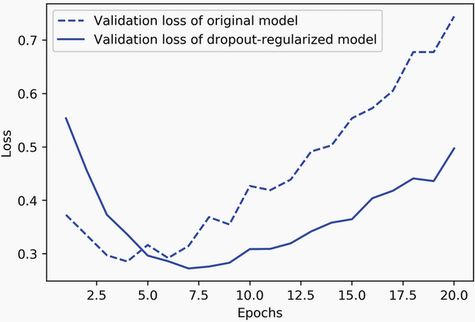

To recap, these are the most common ways to maximize generalization and prevent overfitting in neural networks:

Get more training data, or better training data.

Develop better features.

Reduce the capacity of the model.

Add weight regularization (for smaller models).

Add dropout.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


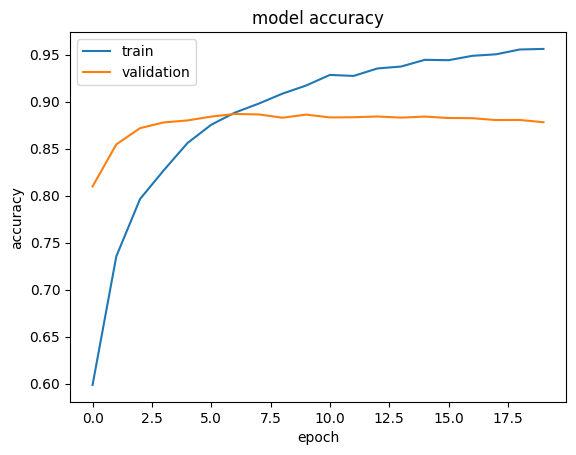

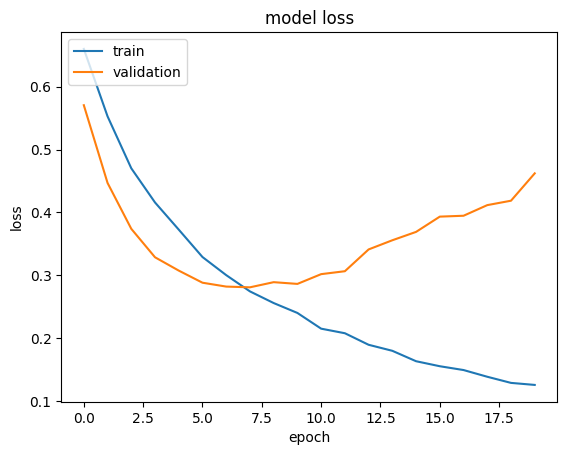

In [17]:
# list all data in history
print(history_dropout.history.keys())
# summarize history for accuracy
plt.plot(history_dropout.history['accuracy'])
plt.plot(history_dropout.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_dropout.history['loss'])
plt.plot(history_dropout.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Summary

The purpose of a machine learning model is to generalize: to perform accurately on never-before-seen inputs. It’s harder than it seems.

A deep neural network achieves generalization by learning a parametric model that can successfully interpolate between training samples—such a model can be said to have learned the “latent manifold” of the training data. This is why deep learning models can only make sense of inputs that are very close to what they’ve seen during training.

The fundamental problem in machine learning is the tension between optimization and generalization: to attain generalization, you must first achieve a good fit to the training data, but improving your model’s fit to the training data will inevitably start hurting generalization after a while. Every single deep learning best practice deals with managing this tension.

The ability of deep learning models to generalize comes from the fact that they manage to learn to approximate the latent manifold of their data, and can thus make sense of new inputs via interpolation.

It’s essential to be able to accurately evaluate the generalization power of your model while you’re developing it. You have at your disposal an array of evaluation methods, from simple holdout validation to K-fold cross-validation and iterated K-fold cross-validation with shuffling. Remember to always keep a completely separate test set for final model evaluation, since information leaks from your validation data to your model may have occurred.

When you start working on a model, your goal is first to achieve a model that has some generalization power and that can overfit. Best practices for doing this include tuning your learning rate and batch size, leveraging better architecture priors, increasing model capacity, or simply training longer.

As your model starts overfitting, your goal switches to improving generalization through model regularization. You can reduce your model’s capacity, add dropout or weight regularization, and use early stopping. And naturally, a larger or better dataset is always the number one way to help a model generalize.

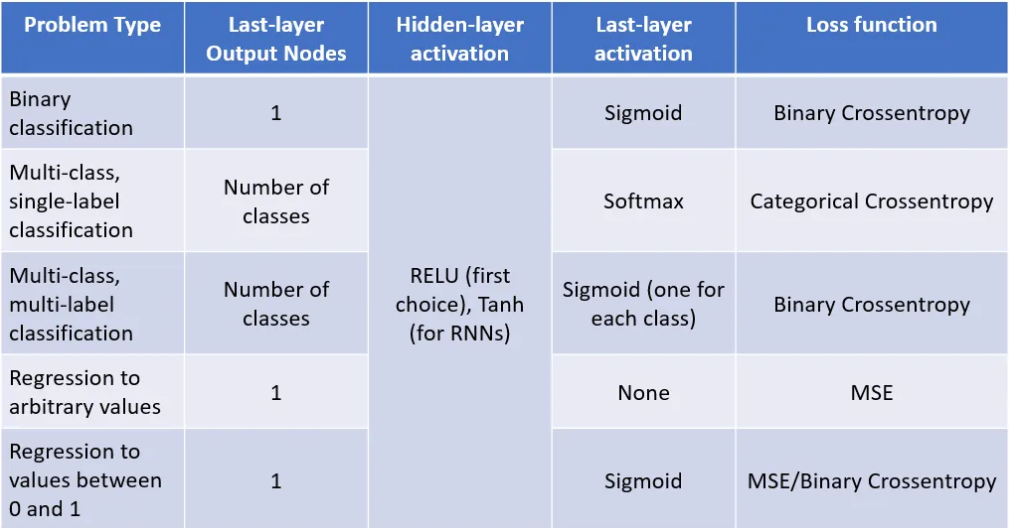